In [1]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [2]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [3]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile

In [5]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [6]:
df.head()

,id,caption,label
1057,1058,পাইলটের শেষ মুহূর্তের প্রচেষ্টা সত্ত্বেও দুর্ঘ...,Anthropogenic
5868,5869,প্যাডেল এক্সারসাইজার মিনি এক্সারসাইজ বাইক আর্ম...,Non Informative
4195,4196,দেশাল ব্লাউজ কালেকশনে প্রতিটি ব্লাউজে রয়েছে হা...,Non Informative
4837,4838,খিচুড়ি - হাস ভুনা - আমের আচার 🌻🌻,Non Informative
4354,4355,কালকে ওরে সোফার রুমে ঘুমে রেখে এসে আমি বেডরুমে...,Non Informative


In [7]:
# Define label mapping
label_mapping = {
    'flood': 0,
    'Cyclone': 1,
    'Earthquake': 2,
    'River Erosion': 3,
    'Fire' : 4,
    'Anthropogenic': 5,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [8]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [9]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [10]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-small")

tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [11]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'Fire' : 4,
            'anthropogenic': 5
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        image_path = os.path.join(self.images_folder, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.png")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 5, f"Label {label} out of range"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }

In [12]:
images_folder = '/kaggle/input/mddb-images/Photos_Final'  # Updated to match dataset source
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, train_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, valid_test_transforms)
test_dataset = MultimodalDataset(test_data, images_folder, tokenizer, valid_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1899
633
634


In [14]:
import torch
import torch.nn as nn
from transformers import XLMRobertaModel
from torchvision import models

class EarlyFusionModel(nn.Module):
    def __init__(self, num_classes=6, roberta_model_name='Davlan/afro-xlmr-small'):
        super(EarlyFusionModel, self).__init__()

        # Text branch: XLM-RoBERTa
        self.roberta = AutoModel.from_pretrained(roberta_model_name)

        # Image branch: EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        # EfficientNet classifier is a Sequential with [Dropout, Linear]
        # We want to remove the last Linear layer and keep the rest
        self.efficientnet.classifier = nn.Sequential(*list(self.efficientnet.classifier.children())[:-1])

        # Get output feature size of EfficientNet after removing classifier layer
        in_features = 1280  # EfficientNet-B0 feature dim after classifier dropout

        # Project image features to match text feature dimension (768 for xlm-roberta-base)
        self.image_proj = nn.Linear(in_features, 768)

        # Combined fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(768 + 768, 512),  # 768 text + 768 image features concatenated
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # Text features with mean pooling on last_hidden_state
        text_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = text_outputs.last_hidden_state  # (batch_size, seq_len, 768)
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
        text_features = torch.sum(last_hidden * mask_expanded, dim=1) / torch.clamp(mask_expanded.sum(dim=1), min=1e-9)

        # Image features from EfficientNet (excluding classifier layer)
        image_features = self.efficientnet(image)  # (batch_size, 1280)
        image_features = self.image_proj(image_features)  # (batch_size, 768)

        # Concatenate text and image features
        combined_features = torch.cat((text_features, image_features), dim=1)

        # Pass through classifier layers
        logits = self.fc(combined_features)
        return logits


In [15]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EarlyFusionModel(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Training loop with early stopping
num_epochs = 10
patience = 3
early_stop_counter = 0
best_valid_loss = float('inf')
best_model_path = 'best_model.pth'
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * input_ids.size(0)

    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")

    scheduler.step(valid_loss)

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load(best_model_path))
# model.eval()

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficient

Epoch 1/10, Train Loss: 1.7575, Val Loss: 1.6229


Epoch 2/10: 100%|██████████| 119/119 [00:52<00:00,  2.27it/s]


Epoch 2/10, Train Loss: 1.3223, Val Loss: 0.8922


Epoch 3/10: 100%|██████████| 119/119 [00:53<00:00,  2.24it/s]


Epoch 3/10, Train Loss: 0.7609, Val Loss: 0.6162


Epoch 4/10: 100%|██████████| 119/119 [00:53<00:00,  2.23it/s]


Epoch 4/10, Train Loss: 0.4749, Val Loss: 0.4123


Epoch 5/10: 100%|██████████| 119/119 [00:53<00:00,  2.24it/s]


Epoch 5/10, Train Loss: 0.3136, Val Loss: 0.2993


Epoch 6/10: 100%|██████████| 119/119 [00:52<00:00,  2.26it/s]


Epoch 6/10, Train Loss: 0.2584, Val Loss: 0.2687


Epoch 7/10: 100%|██████████| 119/119 [00:52<00:00,  2.28it/s]


Epoch 7/10, Train Loss: 0.1797, Val Loss: 0.2158


Epoch 8/10: 100%|██████████| 119/119 [00:52<00:00,  2.27it/s]


Epoch 8/10, Train Loss: 0.1374, Val Loss: 0.2074


Epoch 9/10: 100%|██████████| 119/119 [00:52<00:00,  2.27it/s]


Epoch 9/10, Train Loss: 0.0971, Val Loss: 0.2294


Epoch 10/10: 100%|██████████| 119/119 [00:51<00:00,  2.29it/s]


Epoch 10/10, Train Loss: 0.0803, Val Loss: 0.1929


<ipython-input-15-eba6249a7f9e>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>


Test Set Evaluation:
Accuracy: 0.9369
Precision: 0.9388
Recall: 0.9369
F1 Score: 0.9372

Classification Report:
               precision    recall  f1-score   support

        flood       0.93      0.93      0.93       114
      cyclone       0.88      0.94      0.91        93
   earthquake       0.88      0.95      0.91        84
river erosion       0.96      0.91      0.93       101
         fire       0.98      0.98      0.98       112
anthropogenic       0.98      0.92      0.94       130

     accuracy                           0.94       634
    macro avg       0.93      0.94      0.94       634
 weighted avg       0.94      0.94      0.94       634



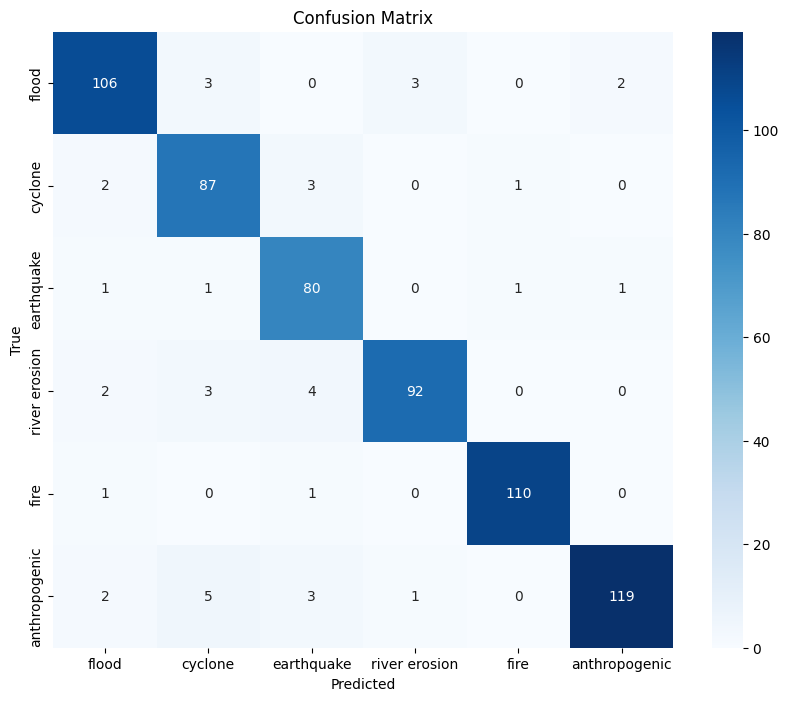

In [16]:
# Evaluation on test set
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'], yticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


📉 Epoch-wise Losses:
Epoch  1: Train Loss = 1.7575, Val Loss = 1.6229
Epoch  2: Train Loss = 1.3223, Val Loss = 0.8922
Epoch  3: Train Loss = 0.7609, Val Loss = 0.6162
Epoch  4: Train Loss = 0.4749, Val Loss = 0.4123
Epoch  5: Train Loss = 0.3136, Val Loss = 0.2993
Epoch  6: Train Loss = 0.2584, Val Loss = 0.2687
Epoch  7: Train Loss = 0.1797, Val Loss = 0.2158
Epoch  8: Train Loss = 0.1374, Val Loss = 0.2074
Epoch  9: Train Loss = 0.0971, Val Loss = 0.2294
Epoch 10: Train Loss = 0.0803, Val Loss = 0.1929


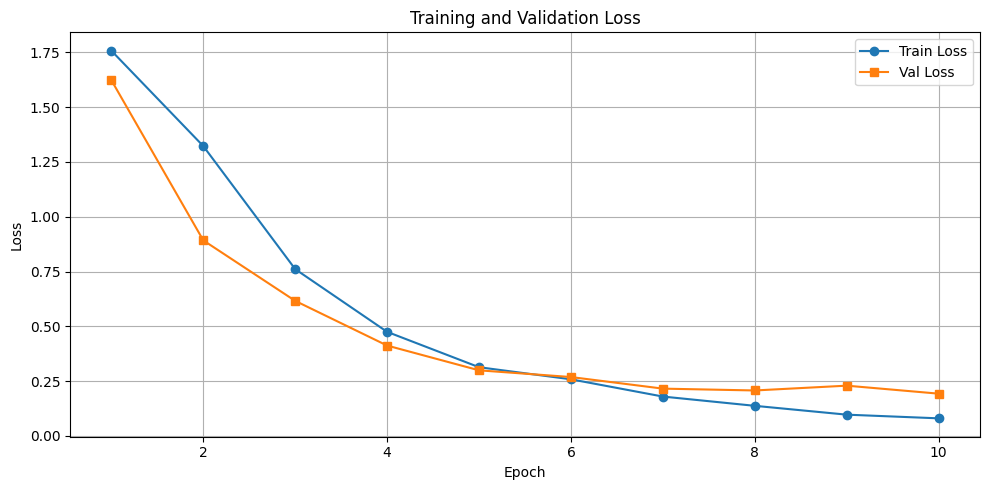

In [17]:
import matplotlib.pyplot as plt

# Print epoch-wise losses
print("\n📉 Epoch-wise Losses:")
for i, (train, val) in enumerate(zip(train_losses, valid_losses), start=1):
    print(f"Epoch {i:2d}: Train Loss = {train:.4f}, Val Loss = {val:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Val Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
